In [401]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import itertools
import time
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('insurance.csv')

In [402]:
def var_transform(data):
    
    binned_bmi = pd.qcut(data['bmi'], 7, retbins = True)
    bins = binned_bmi[1]
    data['bmi_binned'] = pd.cut(data['bmi'], bins = bins)
    
    return data

In [403]:
data = var_transform(data)

In [404]:
# randomly create test and training dataset
np.random.seed(10)

train = data.sample(round(data.shape[0]*0.8)) # 80% i.e. 
test = data.drop(train.index)
train

,age,sex,bmi,children,smoker,region,charges,bmi_binned
7,37,female,27.740,3,no,northwest,7281.50560,"(26.98, 29.3]"
999,36,female,26.885,0,no,northwest,5267.81815,"(24.09, 26.98]"
1209,59,male,37.100,1,no,southwest,12347.17200,"(33.915, 37.1]"
491,61,female,25.080,0,no,southeast,24513.09126,"(24.09, 26.98]"
625,29,female,26.030,0,no,northwest,3736.46470,"(24.09, 26.98]"
...,...,...,...,...,...,...,...,...
587,34,female,30.210,1,yes,northwest,43943.87610,"(29.3, 31.54]"
737,26,male,23.700,2,no,southwest,3484.33100,"(15.96, 24.09]"
488,44,female,38.060,0,yes,southeast,48885.13561,"(37.1, 53.13]"
1316,19,female,20.600,0,no,southwest,1731.67700,"(15.96, 24.09]"


In [405]:
test = pd.get_dummies(test)
train = pd.get_dummies(train)
train

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,"bmi_binned_(15.96, 24.09]","bmi_binned_(24.09, 26.98]","bmi_binned_(26.98, 29.3]","bmi_binned_(29.3, 31.54]","bmi_binned_(31.54, 33.915]","bmi_binned_(33.915, 37.1]","bmi_binned_(37.1, 53.13]"
7,37,27.740,3,7281.50560,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0
999,36,26.885,0,5267.81815,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0
1209,59,37.100,1,12347.17200,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0
491,61,25.080,0,24513.09126,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0
625,29,26.030,0,3736.46470,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,34,30.210,1,43943.87610,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0
737,26,23.700,2,3484.33100,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0
488,44,38.060,0,48885.13561,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1
1316,19,20.600,0,1731.67700,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0


In [406]:
test.columns = test.columns.str.replace(' ','')
train.columns = train.columns.str.replace(' ','')
test.columns = test.columns.str.replace('.', '', regex=True)
train.columns = train.columns.str.replace('.', '', regex=True)
test.columns = test.columns.str.replace('(', '', regex=True)
train.columns = train.columns.str.replace('(', '', regex=True)
test.columns = test.columns.str.replace(']', '', regex=True)
train.columns = train.columns.str.replace(']', '', regex=True)
test.columns = test.columns.str.replace(',', '', regex=True)
train.columns = train.columns.str.replace(',', '', regex=True)

cols = train.columns.tolist()
cols.remove('charges')
cols.remove('bmi')

In [407]:
# Use VIF to find collinearity

x = train[cols]
X = train[cols]
X_backup = train[cols]

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
x = add_constant(x)
vif_data = pd.DataFrame()
vif_data["feature"] = x.columns

for i in range(len(x.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(x.values, i)

vif_data[:]

,feature,VIF
0,const,0.000000
1,age,1.024704
2,children,1.011380
3,sex_female,inf
4,sex_male,inf
5,smoker_no,inf
6,smoker_yes,inf
7,region_northeast,inf
8,region_northwest,inf
9,region_southeast,inf


In [408]:
x = train[cols]
X = train[cols]
X_backup = train[cols]
    
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.ols('charges~' + '+'.join(predictor_subset), data = train).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}

#Function to select the best model amongst all models with 'k' predictors
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(x.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')

In [339]:
# Forward Selection

x = train[cols]
X = train[cols]
X_backup = train[cols]

#Including 2-factor interactions of predictors in train and 'X'. Note that we need train to develop the model, and X to 
#find 'k' variable subsets from amongst all the predictors under consideration
for combo in itertools.combinations(X_backup.columns, 2):    
    train['_'.join(combo)] = train[combo[0]]*train[combo[1]]
    test['_'.join(combo)] = test[combo[0]]*test[combo[1]]
    X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)] 
    
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

def forward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

models_best = forward_selection()
print(best_sub_plots())

Processed  153 models on 1 predictors in 0.982907772064209 seconds.
Processed  152 models on 2 predictors in 1.4597680568695068 seconds.
Processed  151 models on 3 predictors in 1.571563959121704 seconds.
Processed  150 models on 4 predictors in 1.9385359287261963 seconds.
Processed  149 models on 5 predictors in 2.164238214492798 seconds.
Processed  148 models on 6 predictors in 1.8697662353515625 seconds.
Processed  147 models on 7 predictors in 1.7625079154968262 seconds.
Processed  146 models on 8 predictors in 1.9325871467590332 seconds.
Processed  145 models on 9 predictors in 2.1763551235198975 seconds.
Processed  144 models on 10 predictors in 2.325577974319458 seconds.
Processed  143 models on 11 predictors in 2.5644469261169434 seconds.
Processed  142 models on 12 predictors in 3.1094508171081543 seconds.
Processed  141 models on 13 predictors in 2.9252121448516846 seconds.
Processed  140 models on 14 predictors in 3.0616321563720703 seconds.
Processed  139 models on 15 predi


KeyboardInterrupt



In [305]:
# Best Forward Model

best_fwd_reg_model = models_best['model'][27] #10
best_fwd_reg_model.summary()

KeyError: 27

In [311]:
#RMSE for Best Forward Selection

pred = best_fwd_reg_model.predict(test)
print(np.sqrt(((pred - test.charges)**2).mean())) #10: 4796, 9: 4799, 8: 4853 7: 4779 6: 4815 
                                                  #11: 4819 12: 4803 13: 4807 14: 4820 
cols

6142.529379851995


['age',
 'children',
 'sex_female',
 'sex_male',
 'smoker_no',
 'smoker_yes',
 'region_northeast',
 'region_northwest',
 'region_southeast',
 'region_southwest',
 'bmi_binned_15962409',
 'bmi_binned_24092698',
 'bmi_binned_2698293',
 'bmi_binned_2933154',
 'bmi_binned_315433915',
 'bmi_binned_33915371',
 'bmi_binned_3715313']

Processed  17 models on 16 predictors in 0.5158331394195557 seconds.
Processed  16 models on 15 predictors in 0.35631299018859863 seconds.
Processed  15 models on 14 predictors in 0.32617807388305664 seconds.
Processed  14 models on 13 predictors in 0.3248908519744873 seconds.
Processed  13 models on 12 predictors in 0.22358107566833496 seconds.
Processed  12 models on 11 predictors in 0.21610689163208008 seconds.
Processed  11 models on 10 predictors in 0.18097281455993652 seconds.
Processed  10 models on 9 predictors in 0.15364384651184082 seconds.
Processed  9 models on 8 predictors in 0.11586403846740723 seconds.
Processed  8 models on 7 predictors in 0.10130620002746582 seconds.
Processed  7 models on 6 predictors in 0.08621788024902344 seconds.
Processed  6 models on 5 predictors in 0.05538201332092285 seconds.
Processed  5 models on 4 predictors in 0.04125094413757324 seconds.
Processed  4 models on 3 predictors in 0.03332400321960449 seconds.
Processed  3 models on 2 predictors

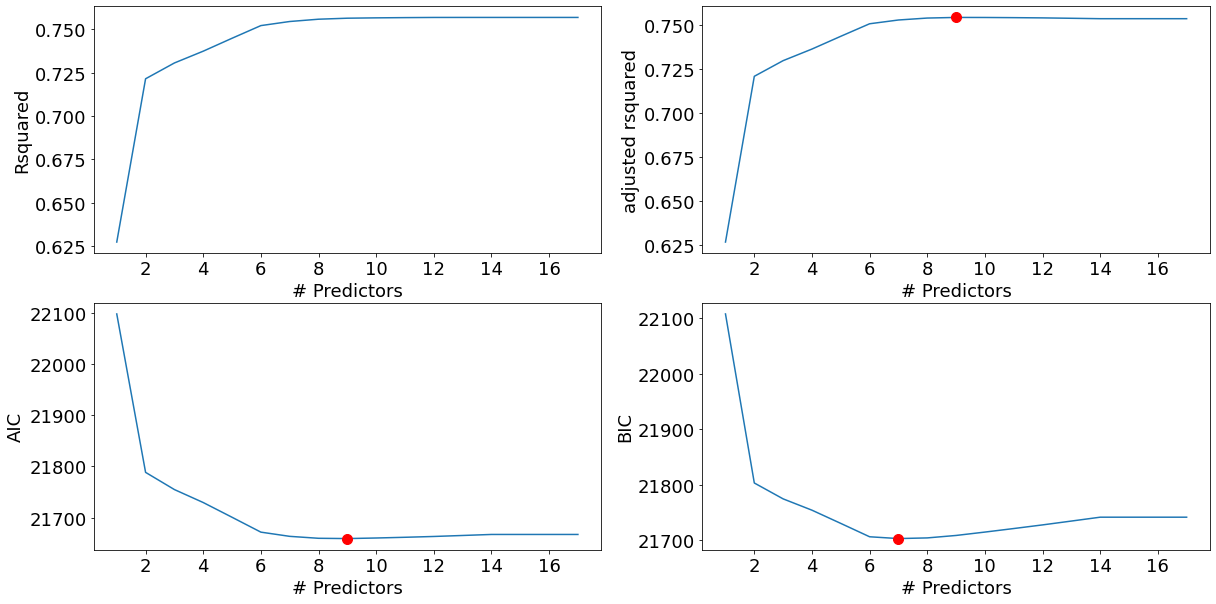

In [410]:
# Backward Selection

x = train[cols]
X = train[cols]
X_backup = train[cols]

for combo in itertools.combinations(X_backup.columns, 2):    
    train['_'.join(combo)] = train[combo[0]]*train[combo[1]]
    test['_'.join(combo)] = test[combo[0]]*test[combo[1]]
    X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)] 

def backward(predictors):    
    tic = time.time()
    results = []
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    # Return the best model, along with some other useful information about the model
    return best_model

def backward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"], index = range(1,len(x.columns)))
    tic = time.time()
    predictors = x.columns
    models_best.loc[len(predictors)] = processSubset(predictors)
    while(len(predictors) > 1):  
        models_best.loc[len(predictors)-1] = backward(predictors)
        predictors = models_best.loc[len(predictors)-1]["model"].params.index[1:]
    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

models_best = backward_selection()
print(best_sub_plots())

In [310]:
# Best Backward Model

best_bwd_reg_model = models_best['model'][16] #7 with Bins
best_bwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     234.5
Date:                Thu, 09 Mar 2023   Prob (F-statistic):          7.72e-312
Time:                        18:46:34   Log-Likelihood:                -10819.
No. Observations:                1070   AIC:                         2.167e+04
Df Residuals:                    1055   BIC:                         2.174e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             3908.7961   3016.534      1.296      0.195   -2010.292    9827.885
age                    247.6266     13.209     18.747      0.000     221.707     273.546
children               512.1849    152.010      3.369      0.001     213.909     810.461
sex_female            2094.0592   1526.050      1.372      0.170    -900.379    5088.498
sex_male              1814.7370   1513.078      1.199      0.231   -1154.247    4783.721
smoker_no            -9941.9348   1516.040     -6.558      0.000   -1.29e+04   -6967.138
smoker_yes            1.385e+04   1534.990      9.023      0.000    1.08e+04    1.69e+04
region_northeast      1455.9191    540.529      2.694      0.007     395.284    2516.554
region_northwest       593.0530    524.698      1.130      0.259    -436.517    1622.624
region_southeast       341.4021    522.712      0.653      0.514    -684.271    1367.076
bmi_binned_15962409  -1367.4914   6032.527     -0.227      0.821   -1.32e+04    1.05e+04
bmi_binned_24092698   -497.9964   6037.463     -0.082      0.934   -1.23e+04    1.13e+04
bmi_binned_2698293    -354.8427   6038.768     -0.059      0.953   -1.22e+04    1.15e+04
bmi_binned_2933154    2457.2975   6035.935      0.407      0.684   -9386.505    1.43e+04
bmi_binned_315433915  3236.3033   6040.159      0.536      0.592   -8615.788    1.51e+04
bmi_binned_33915371   4631.4719   6041.295      0.767      0.443   -7222.848    1.65e+04
bmi_binned_3715313    3866.1382   6043.765      0.640      0.523   -7993.029    1.57e+04
==============================================================================
Omnibus:                      240.053   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              559.864
Skew:                           1.211   Prob(JB):                    2.67e-122
Kurtosis:                       5.587   Cond. No.                     3.88e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.23e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [299]:
#RMSE for Best Backward Selection

pred = best_bwd_reg_model.predict(test)
print(np.sqrt(((pred - test.charges)**2).mean())) #7: 6109 8: 6147 9: 6142 3: 6439 4: 6261 5: 6175 6: 6125

6261.444151317975


In [400]:
#RMSE for Original Model
# randomly create test and training dataset
np.random.seed(2)

train = data.sample(round(data.shape[0]*0.8)) # 80% i.e. 
test = data.drop(train.index)
train

model2 = sm.ols(formula = 'charges ~ age+ np.log(age) + bmi_binned*children+I(children**2) +children*smoker + bmi_binned*smoker', 
                     data = train).fit()
pred2 = model2.predict(test)
print(np.sqrt(((pred2 - test.charges)**2).mean()))

orig_model = sm.ols(formula = 'charges ~ age + children + region + bmi_binned * smoker', 
                     data = train).fit()
orig_pred = orig_model.predict(test)
print(np.sqrt(((orig_pred - test.charges)**2).mean()))

4222.437164551717
4200.602968040169
